<a href="https://colab.research.google.com/github/alby1976/Data607608Project/blob/master/notebook/OffenderProfile(GNB%26RF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Can We Predict The Offender Profile? 
#### Data 607 - Group 4

Continuing this exploration of the data, we wanted to see if we could predict the Offender Profile. This would be an extremely helpful tool for investigators to help reduce the number of suspects in a case. Though there are some concerns that this algorithim could be used to profile individuals, building these models can also be used to reduce the number of innocent people being convicted. Improve the accuracy and limiting the number of false positive would have a positive effect on society.  

For example, there is a long standing but false stereotype that black males tend to be overly aggressive toward white females and pose a significant threat to them. This idea is perpetuated in many movies, songs, and books such as "To Kill a Mockingbird". However, Looking through the data it shows that this stereotype is not correlated with reality as it is far more likely for white females to be murder by a white male compared to a black male (75.11% vs 12.73% for all cases).

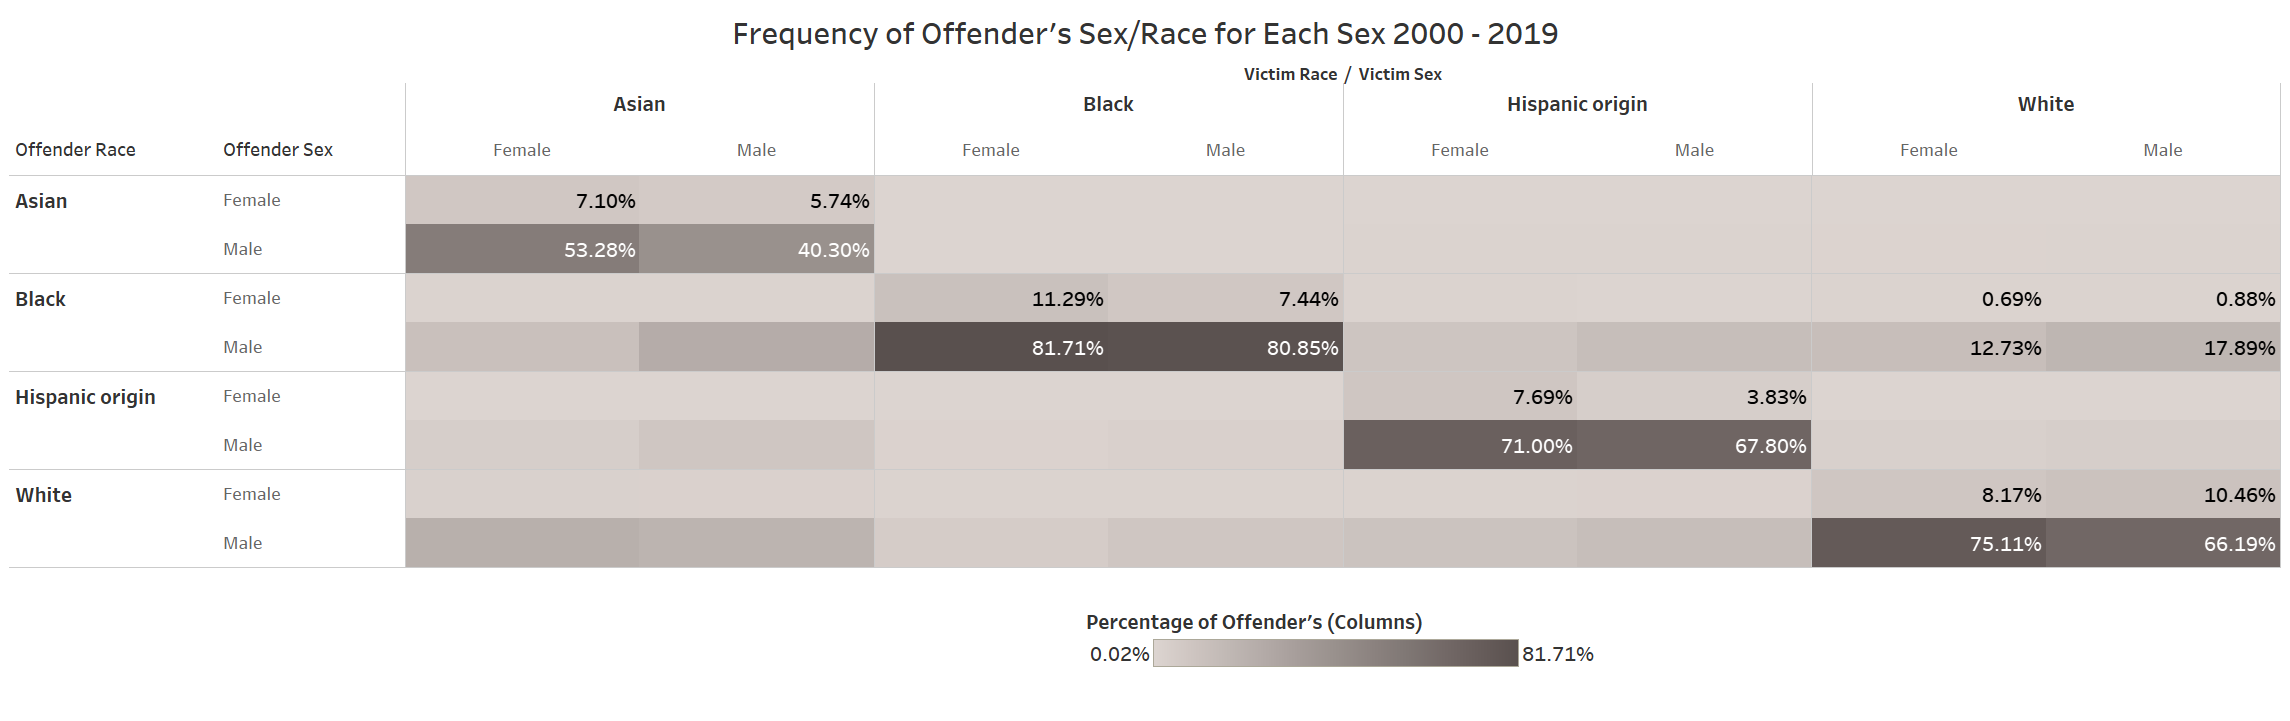




Establishing good classifiers can help combat this bias in the police force and help reduce the number of false imprisonments. To start building classifiers for this problem we are going to be predicting the offender data on cases where we have vata values. In every unsolved case in the data, the offender profile (Age, Race, Sex) has a dummy values set as it is impossible to test the accuracy of any predictions on these values. However, we can still train and test a model on known data to see if it could be effective in predicting the characteristics of unsolved murder cases.  

To do this we attempted to construct an GNB & Random Forest Classifier of the temporal data in our dataset to see if we can train an effective model.

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

In [ ]:
#Imports using google.colab
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive

MAP = pd.read_csv("/content/gdrive/MyDrive/SHR76_19.csv")


 cloud_class_activity.pptx
'Colab Notebooks'
'Galvanic Corrosion.PNG'
 GraemeKempthorne-Coverletter.docx
'GraemeKempthorne_Coverletter(Kinaxis).docx'
 GraemeKempthorne-Coverletter.odt
'GraemeKempthorne_Coverletter(Shop).docx'
'Graeme Kempthorne Resume.pdf'
 HR
 IMG_20210105_165006.jpg
 Investing
 pre-2020
 Python-for-Data-Analysis-Textboot.pdf
'SandolPark_Capstone_Rough Draft_no.2.docx'
 SHR76_19.csv
'Terriers Were Once The Greatest Dogs In The.pptx'
 VID_20210111_135925.mp4


In [ ]:
df = MAP[['CNTYFIPS', 'State', 'Solved','Year', 'Incident', 'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount', 'OffAge', 'OffSex', 'OffRace']]
df = df[(df["Year"] >= 2000) & (df["Year"] <= 2019)].reset_index()
df = df.dropna()

In [ ]:
print(df.keys(), '\n', df.shape)
df.head()

Index(['index', 'CNTYFIPS', 'State', 'Solved', 'Year', 'Incident', 'Homicide',
       'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum', 'VicCount', 'OffCount',
       'OffAge', 'OffSex', 'OffRace'],
      dtype='object') 
 (15044, 21)


,index,CNTYFIPS,State,Solved,Year,Incident,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,OffAge,OffSex,OffRace
6,452,"Anchorage, AK",Alaska,Yes,2000,2,Murder and non-negligent manslaughter,Single victim/multiple offenders,32,Male,White,Unknown or not reported,Rifle,Stranger,Felon killed by police,Felon attacked fellow police officer,0,2,39,Male,White
15,461,"Anchorage, AK",Alaska,Yes,2001,1,Murder and non-negligent manslaughter,Single victim/single offender,28,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Felon killed by private citizen,Felon killed in commission of a crime,0,0,45,Male,White
30,476,"Anchorage, AK",Alaska,No,2002,1,Murder and non-negligent manslaughter,Single victim/unknown offender(s),23,Male,White,Unknown or not reported,Rifle,Relationship not determined,Felon killed by police,Felon attacked police officer,0,0,999,Unknown,Unknown
46,492,"Anchorage, AK",Alaska,No,2002,1,Murder and non-negligent manslaughter,Single victim/unknown offender(s),33,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Felon killed by police,Felon killed in commission of a crime,0,0,999,Unknown,Unknown
74,520,"Anchorage, AK",Alaska,Yes,2004,2,Murder and non-negligent manslaughter,Single victim/single offender,28,Male,White,Unknown or not reported,Knife or cutting instrument,Stranger,Felon killed by private citizen,Felon killed in commission of a crime,0,0,48,Male,White


For this exploration we are dropping the the data points from the years before 2000 as a way to improve the accuracy of the model.  The demographics of communities and states have changed significantly over the years and keeping information from many years ago is likely to skew or bias our results to crime rates and demographics from decades ago.  

In these models we are looking to see if we can predict the offender profile on 3 different metrics (Offender Age, Offender Sex, and Offender Race).

Text(0.5, 0.98, 'Offender Distribution of Sex')

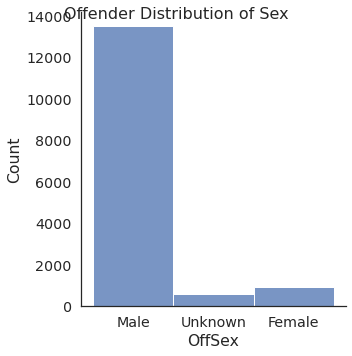

In [ ]:
g = sns.displot(df, x="OffSex")
plt.suptitle("Offender Distribution of Sex", fontsize=16)

Text(0.5, 0.98, 'Offender Distribution of Race')

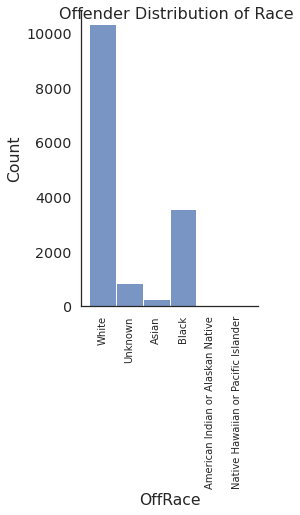

In [ ]:
g = sns.displot(df, x="OffRace")
g.set_xticklabels(rotation=90, fontsize = 10)
plt.suptitle("Offender Distribution of Race", fontsize=16)


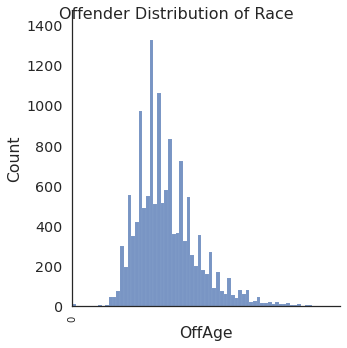

In [ ]:
g = sns.displot(df, x="OffAge")
g.set_xticklabels(rotation=90, fontsize = 10)
plt.suptitle("Offender Distribution of Race", fontsize=16)
g.set(xlim=(0, 100))

In [ ]:
# For preprocessing the data
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
Homicide_cat = le.fit_transform(df.Homicide)
State_cat = le.fit_transform(df.State)
VicSex_cat = le.fit_transform(df.VicSex) 
VicRace_cat = le.fit_transform(df.VicRace)
VicEthnic_cat = le.fit_transform(df.VicEthnic)
Weapon_cat = le.fit_transform(df.Weapon)
Relationship_cat = le.fit_transform(df.Relationship)
Circumstance_cat = le.fit_transform(df.Circumstance)
Subcircum_cat = le.fit_transform(df.Subcircum)
OffSex_cat = le.fit_transform(df.OffSex)
OffRace_cat = le.fit_transform(df.OffRace)
#print(list(le.classes_))


# initialize the encoded categorical columns
df['Homicide_cat'] = Homicide_cat
df['State_cat'] = State_cat
df['VicSex_cat'] = VicSex_cat 
df['VicRace_cat'] = VicRace_cat
df['VicEthnic_cat'] = VicEthnic_cat
df['Weapon_cat'] = Weapon_cat
df['Relationship_cat'] = Relationship_cat
df['Circumstance_cat'] = Circumstance_cat
df['OffSex_cat'] = OffSex_cat
df['OffRace_cat'] = OffRace_cat

In [ ]:
df.keys()

Index(['index', 'CNTYFIPS', 'State', 'Solved', 'Year', 'Incident', 'Homicide',
       'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum', 'VicCount', 'OffCount',
       'OffAge', 'OffSex', 'OffRace', 'Homicide_cat', 'State_cat',
       'VicSex_cat', 'VicRace_cat', 'VicEthnic_cat', 'Weapon_cat',
       'Relationship_cat', 'Circumstance_cat', 'OffSex_cat', 'OffRace_cat'],
      dtype='object')

In [ ]:

dummy_fields = ['index','CNTYFIPS', 'State', 'Solved', 'Homicide',
       'Situation', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum', 'OffSex', 'OffRace']
df_GNB_Train = df[df.Solved == 'Yes']
df_GNB_Predict = df[df.Solved == 'No']

In [ ]:
df_GNB_Train = df_GNB_Train.drop(dummy_fields, axis = 1)
df_GNB_Predict = df_GNB_Predict.drop(dummy_fields, axis = 1)
df_GNB_Train

,Year,Incident,VicAge,VicCount,OffCount,OffAge,Homicide_cat,State_cat,VicSex_cat,VicRace_cat,VicEthnic_cat,Weapon_cat,Relationship_cat,Circumstance_cat,OffSex_cat,OffRace_cat
6,2000,2,32,0,2,39,1,1,1,5,2,10,23,1,1,5
15,2001,1,28,0,0,45,1,1,1,5,2,5,0,2,1,5
74,2004,2,28,0,0,48,1,1,1,5,2,6,23,2,1,5
76,2004,1,18,0,0,41,1,1,1,1,2,5,23,2,1,5
78,2004,1,18,0,0,19,1,1,1,5,2,6,0,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324303,2003,1,27,0,0,54,1,50,1,5,2,5,23,1,1,5
324325,2005,1,20,0,0,30,1,50,1,5,2,5,23,1,1,5
324412,2018,2,38,0,1,27,1,50,1,5,1,5,17,1,1,5
324413,2018,1,21,0,0,31,1,50,1,5,1,5,17,1,1,5


In the dataset, dummy values are set for unsolved cases where the offender Age is usually set to 999 and the other variables are left as 'unknown'. This provides no useful training information but is important for our validation and accuracy steps.  In order to properly train the model, we are only going to look at solved cases to see if we can use those to predict the unsolved offender cases.  This introduces some bias into the model as there is likely some reason why specific cases go unsolved where as other cases get solved.    

In [ ]:
df_GNB_Train_Reduce = df_GNB_Train.drop(['OffAge', 'OffRace_cat', 'OffSex_cat'], axis = 1) #Predictions would not have the other Offender information in the actual prediction model so it doesn't make sense to include it in the prediction model
X_Sex = df_GNB_Train_Reduce.values.astype(float)
y_Sex = (df_GNB_Train.OffSex_cat.values).astype(int) # ( 0 = female, 1 = male, 2 = unknown )
print(X_Sex.shape, y_Sex.shape)

(14427, 13) (14427,)


### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [ ]:
# Split data into training and test datasets
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Sex, y_Sex, test_size = 0.2)

# fit a model
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)

# calculate training error
y_pr_tr = gnb.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

# calculate testing error
y_pr = gnb.predict(X_te)
GNBSex_test_err = np.mean(y_pr != y_te)
print(f"testing error = {GNBSex_test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.268538 training error = 0.272940


We can also use this approach to predict the other offender profile columns in a similar fashion. Below is a GNB predicting the Race of the Offender.

In [ ]:

X_Race = df_GNB_Train_Reduce.values.astype(float)
y_Race = (df_GNB_Train.OffRace_cat.values).astype(int) # ['American Indian or Alaskan Native', 'Asian', 'Black', 'Native Hawaiian or Pacific Islander', 'Unknown', 'White'])
print(X_Race.shape, y_Race.shape)

(14427, 13) (14427,)


In [ ]:
# Split data into training and test datasets
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Race, y_Race, test_size = 0.2)

# fit a model
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)

# calculate training error
y_pr_tr = gnb.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

# calculate testing error
y_pr = gnb.predict(X_te)
GNBRace_test_err = np.mean(y_pr != y_te)
print(f"testing error = {GNBRace_test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.251213 training error = 0.245386


With Training and Testing errors above 60%, it shows that there is a lot of variation within the dataset and it is difficult to predict the Race of the offender with this approach.  

In [ ]:

X_Age = df_GNB_Train_Reduce.values.astype(float)
y_Age = (df_GNB_Train.OffAge.values).astype(int) 
print(X_Age.shape, y_Age.shape)

(14427, 13) (14427,)


In [ ]:
# Split data into training and test datasets
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Age, y_Age, test_size = 0.2)

# fit a model
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)

# calculate training error
y_pr_tr = gnb.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

# calculate testing error
y_pr = gnb.predict(X_te)
test_err = np.mean(y_pr != y_te)
print(f"testing error = {test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.988912 training error = 0.987436


Similarily with Age, high error rates show that The Age of the offender is difficult to predict.  To see if the values are significantly off, we can see if the GNB model predictions are coming close to the actual values through binning the age values within the data. 

In [ ]:
bins = list(range(0,100,10))
df_GNB_Train_Age = df_GNB_Train.copy()
df_GNB_Train_Age['OffAge_Bin']  = pd.cut(df_GNB_Train_Age['OffAge'], bins=bins)
OffAge_bin = le.fit_transform(df_GNB_Train_Age.OffAge_Bin.astype(str))
df_GNB_Train_Age['OffAge_cat'] = OffAge_bin
df_GNB_Train_Age

,Year,Incident,VicAge,VicCount,OffCount,OffAge,Homicide_cat,State_cat,VicSex_cat,VicRace_cat,VicEthnic_cat,Weapon_cat,Relationship_cat,Circumstance_cat,OffSex_cat,OffRace_cat,OffAge_Bin,OffAge_cat
6,2000,2,32,0,2,39,1,1,1,5,2,10,23,1,1,5,"(30, 40]",3
15,2001,1,28,0,0,45,1,1,1,5,2,5,0,2,1,5,"(40, 50]",4
74,2004,2,28,0,0,48,1,1,1,5,2,6,23,2,1,5,"(40, 50]",4
76,2004,1,18,0,0,41,1,1,1,1,2,5,23,2,1,5,"(40, 50]",4
78,2004,1,18,0,0,19,1,1,1,5,2,6,0,2,1,5,"(10, 20]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324303,2003,1,27,0,0,54,1,50,1,5,2,5,23,1,1,5,"(50, 60]",5
324325,2005,1,20,0,0,30,1,50,1,5,2,5,23,1,1,5,"(20, 30]",2
324412,2018,2,38,0,1,27,1,50,1,5,1,5,17,1,1,5,"(20, 30]",2
324413,2018,1,21,0,0,31,1,50,1,5,1,5,17,1,1,5,"(30, 40]",3


In [ ]:
df_GNB_Train_Age = df_GNB_Train_Age.drop(['OffAge_Bin', 'OffAge'], axis = 1)
df_GNB_Train_Age

,Year,Incident,VicAge,VicCount,OffCount,Homicide_cat,State_cat,VicSex_cat,VicRace_cat,VicEthnic_cat,Weapon_cat,Relationship_cat,Circumstance_cat,OffSex_cat,OffRace_cat,OffAge_cat
6,2000,2,32,0,2,1,1,1,5,2,10,23,1,1,5,3
15,2001,1,28,0,0,1,1,1,5,2,5,0,2,1,5,4
74,2004,2,28,0,0,1,1,1,5,2,6,23,2,1,5,4
76,2004,1,18,0,0,1,1,1,1,2,5,23,2,1,5,4
78,2004,1,18,0,0,1,1,1,5,2,6,0,2,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324303,2003,1,27,0,0,1,50,1,5,2,5,23,1,1,5,5
324325,2005,1,20,0,0,1,50,1,5,2,5,23,1,1,5,2
324412,2018,2,38,0,1,1,50,1,5,1,5,17,1,1,5,2
324413,2018,1,21,0,0,1,50,1,5,1,5,17,1,1,5,3


In [ ]:
X_Age = df_GNB_Train_Reduce.values.astype(float)
y_Age = (df_GNB_Train_Age.OffAge_cat.values).astype(int) 
# Split data into training and test datasets
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Age, y_Age, test_size = 0.2)

# fit a model
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)

# calculate training error
y_pr_tr = gnb.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

# calculate testing error
y_pr = gnb.predict(X_te)
GNBAge_test_err = np.mean(y_pr != y_te)
print(f"testing error = {GNBAge_test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.791060 training error = 0.789446


This binning approach of grouping the age values into bins of 5 years greatly improves the prediction accuracy of this model as it reduces the testing error from 0.772649 down to 0.270052.  However, this approach does leave a lot to be desired and we turn to a random forest approach to see if the model can be improved.  

### Random Forest

We start off this epxloration with a similar approach in training and designing three different random forest models to predict the target feature in the offender profile. Random forest classifers are different from GNB models as they try to find thresholds or node points that allow us to split up the data into different categories (called leaves).  Repeating this several times creates a rule-based classification system where we end up with a prediction based on inputs coming from the training data.  This is an incredibly powerful approach as it produces a very readable model and allows us to identify which variables being added into the model are the most helpful in predicting the target variable.  Random forest is a special type of decision tree where multiple classification trees are tested at the same time and a 'best' classification tree is chosen to create the rule system during the fitting process. 

In [ ]:
df_rf_train = df_GNB_Train.copy()
df_rf_train_Reduce = df_GNB_Train_Reduce.copy()
df_rf_train

,Year,Incident,VicAge,VicCount,OffCount,OffAge,Homicide_cat,State_cat,VicSex_cat,VicRace_cat,VicEthnic_cat,Weapon_cat,Relationship_cat,Circumstance_cat,OffSex_cat,OffRace_cat
6,2000,2,32,0,2,39,1,1,1,5,2,10,23,1,1,5
15,2001,1,28,0,0,45,1,1,1,5,2,5,0,2,1,5
74,2004,2,28,0,0,48,1,1,1,5,2,6,23,2,1,5
76,2004,1,18,0,0,41,1,1,1,1,2,5,23,2,1,5
78,2004,1,18,0,0,19,1,1,1,5,2,6,0,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324303,2003,1,27,0,0,54,1,50,1,5,2,5,23,1,1,5
324325,2005,1,20,0,0,30,1,50,1,5,2,5,23,1,1,5
324412,2018,2,38,0,1,27,1,50,1,5,1,5,17,1,1,5
324413,2018,1,21,0,0,31,1,50,1,5,1,5,17,1,1,5


#### Predicting Offender Sex

In [ ]:
#Sex of the Offender

X_Sex = df_rf_train_Reduce.values.astype(float)
y_Sex = (df_rf_train.OffSex_cat.values).astype(int) # ( 0 = female, 1 = male, 2 = unknown )
print(X_Sex.shape, y_Sex.shape)

(14427, 13) (14427,)


In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Sex, y_Sex, test_size = 0.2)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

np.random.seed(42)
rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfSex_test_err = np.mean(y_pr != y_te)
print(f"testing error = {rfSex_test_err:.6f}", f"training error = {tr_err:.6f}")


testing error = 0.049203 training error = 0.000260


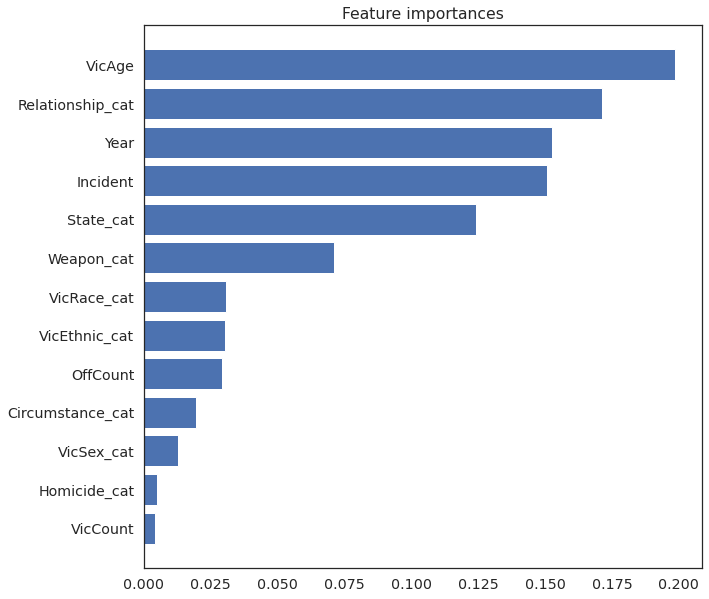

In [ ]:
I = np.argsort(rf.feature_importances_)
df_importance = pd.DataFrame(zip(df_rf_train_Reduce.columns[len(I)-13:len(I)], rf.feature_importances_[len(I)-13:len(I)]))
df_importance = df_importance.sort_values(by=[1], ascending = True)
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(df_importance[0], df_importance[1])
plt.show()

Similar to the GNB method, the random forest is able to accurately predict the offender's sex with a 5% testing error using predictor variables within this dataset.  Of The predictors, we find that the Victim age, Year, and Relationship status of the victim to the offender are the most important predictor variables in determining the sex of the offender. Interesting to note is that the state category is one of the lowest importance indicators in this model and could easily be dropped with limited impact to the testing error.  This indicates that the offender sex profile is does not really change state to state. Next we look to see if the random forest does better in predicting the race or age of the offender compared to the GNB models. To further improve this model, we can use the gridsearch function to tune the hyperparameters within the random forest function.

In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [50, 100, 150, 300],
    "max_depth": [6,10,13],
    "min_samples_leaf" : [1, 2, 4],
    "max_features": ['auto', 'log2', 'sqrt']
}

rf_grid = GridSearchCV(gridsearch_forest, param_grid=params, cv=5 )
rf_grid.fit(X_tr,y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(rf_grid.best_params_)

{'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}


In [ ]:
rf = RandomForestClassifier(n_estimators=150, min_samples_leaf = 1, max_depth = 13, max_features = 'log2',
                            oob_score=True, n_jobs=-1)

rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfSexop = np.mean(y_pr != y_te)
print(f"testing error = {rfSexop:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.049203 training error = 0.035959


Through this gridsearch process for this predicted variable we were not able to find better hyperparameters to reduce the testing and training error. At a 5% test error, it is difficult to improve this measure as the dataset itself has a very high degree of variance along each prediction vector.

#### Predicting Offender Race

In [ ]:

X_Race = df_rf_train_Reduce.values.astype(float)
y_Race = (df_rf_train.OffRace_cat.values).astype(int) 


In [ ]:
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Race, y_Race, test_size = 0.2)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

np.random.seed(42)
rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfRace_test_err = np.mean(y_pr != y_te)
print(f"testing error = {rfRace_test_err:.6f}", f"training error = {tr_err:.6f}")


testing error = 0.180180 training error = 0.000953


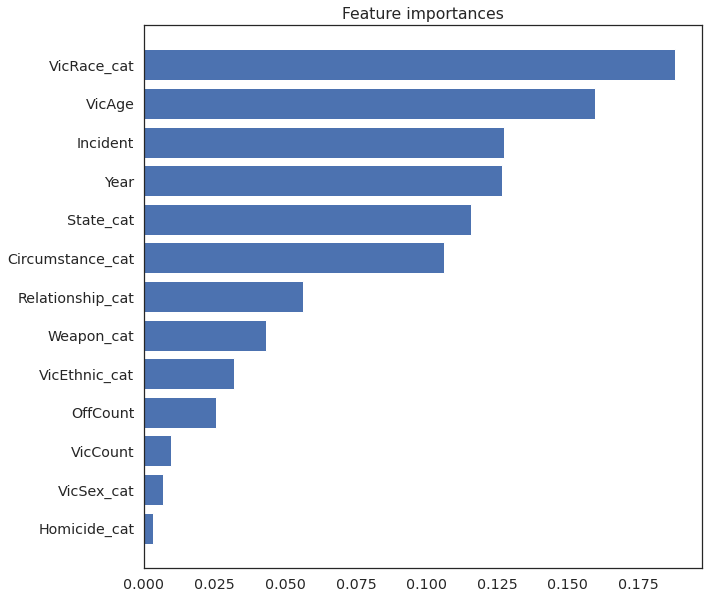

In [ ]:
I = np.argsort(rf.feature_importances_)
df_importance = pd.DataFrame(zip(df_rf_train_Reduce.columns[len(I)-13:len(I)], rf.feature_importances_[len(I)-13:len(I)]))
df_importance = df_importance.sort_values(by=[1], ascending = True)
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(df_importance[0], df_importance[1])
plt.show()

This model follows the previous approach with a gridsearch method to tune the model's hyper parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [50, 100, 150, 300],
    "max_depth": [6,10,13],
    "min_samples_leaf" : [1, 2, 4],
    "max_features": ['auto', 'log2', 'sqrt']
}

rf_grid = GridSearchCV(gridsearch_forest, param_grid=params, cv=5 )
rf_grid.fit(X_tr,y_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(rf_grid.best_params_)

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}


In [ ]:
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf = 1, max_depth = 13, max_features = 'sqrt',
                            oob_score=True, n_jobs=-1)

rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfRaceop = np.mean(y_pr != y_te)
print(f"testing error = {rfRaceop:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.170132 training error = 0.120440


With tuning the hyperparameters for predicting the race of the offender we were able to reduce the testing error from 0.18018 to 016979 and equalize the training error from 0.000953 to 0.120700. By equalizing the training and testing error we limit the possibility of overfitting our model to the test set and be better overall in predicting values in a new dataset. 

#### Predicting Offender Age

In [ ]:
X_Age = df_rf_train_Reduce.values.astype(float)
y_Age = (df_GNB_Train_Age.OffAge_cat.values).astype(int) # Using the categorical bins made from GNB model

In [ ]:
np.random.seed(42)
X_tr, X_te, y_tr, y_te = train_test_split(X_Age, y_Age, test_size = 0.2)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

np.random.seed(42)
rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfAge_test_err = np.mean(y_pr != y_te)
print(f"testing error = {rfAge_test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.621968 training error = 0.003899


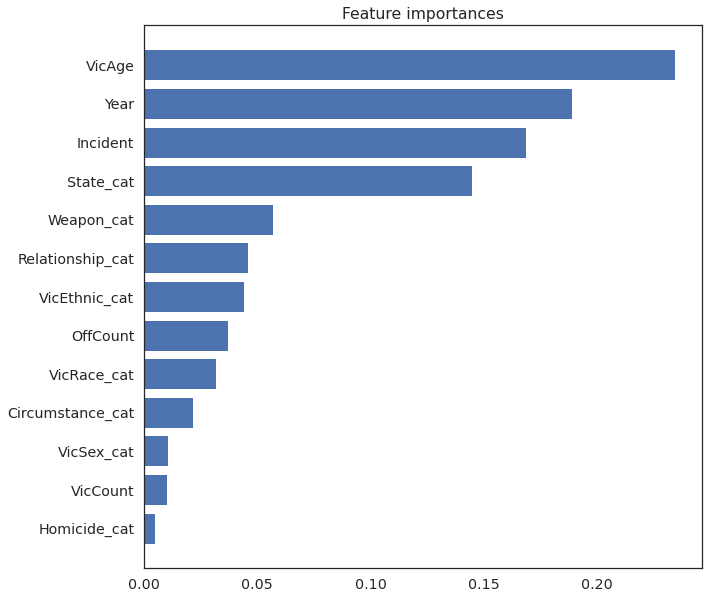

In [ ]:
I = np.argsort(rf.feature_importances_)
df_importance = pd.DataFrame(zip(df_rf_train_Reduce.columns[len(I)-13:len(I)], rf.feature_importances_[len(I)-13:len(I)]))
df_importance = df_importance.sort_values(by=[1], ascending = True)
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(df_importance[0], df_importance[1])
plt.show()

Tuning the parameters for predicting the Age range of the offender. 

In [ ]:

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [50, 100, 150, 300],
    "max_depth": [6,10,13],
    "min_samples_leaf" : [1,2,4],
    "max_features": ['auto', 'log2', 'sqrt']
}

rf_grid = GridSearchCV(gridsearch_forest, param_grid=params, cv=5 )
rf_grid.fit(X_tr,y_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(rf_grid.best_params_)

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}


In [ ]:
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf = 1, max_depth = 13, max_features = 'sqrt',
                            oob_score=True, n_jobs=-1)

rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
rfAgeop = np.mean(y_pr != y_te)
print(f"testing error = {rfAgeop:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.595981 training error = 0.307686


With tuning the hyperparameters for predicting the Age Range of the offender we were able to reduce the testing error from 0.621968 to 0.59633 and equalize the training error from 0.003899 to 0.30673. By equalizing the training and testing error we limit the possibility of overfitting our model to the test set and be better overall in predicting values in a new dataset. 

In [ ]:
GNBmean = np.mean([GNBSex_test_err,GNBRace_test_err,GNBAge_test_err])
rfmean = np.mean([rfSex_test_err, rfRace_test_err, rfAge_test_err])
rfopmean = np.mean([rfSexop, rfRaceop, rfRaceop])
results = pd.DataFrame([[GNBSex_test_err,GNBRace_test_err,GNBAge_test_err, GNBmean],
                        [rfSex_test_err, rfRace_test_err, rfAge_test_err, rfmean],
                        [rfSexop,rfRaceop, rfAgeop,rfopmean]], 
                       index=['GNB', 'Random Forest', 'Optimized Random Forest'],
                       columns=['Sex', 'Race', 'Age', 'Total Average Test Error'])
results.index.name = 'Classifier'
results.columns.name ='Predicted Offender Variable'
results = results.style.set_properties(**{'text-align': 'center'})
results = results.format("{:,.4f}")

display(results)

Predicted Offender Variable,Sex,Race,Age,Total Average Test Error
Classifier,,,,
GNB,0.2685,0.2512,0.7911,0.4369
Random Forest,0.0492,0.1802,0.6220,0.2838
Optimized Random Forest,0.0492,0.1701,0.5960,0.1298


These results show promise for aiding investigators in narrowing down the number of suspects for murder cases. This is especially promising for predicting the offender race as the low test error indicates that the model can rule out certain suspects with a fairly high degree of accuracy.  Predicting the Offender's Sex also has a very low test error rate but the dataset is heavily skewed with male offenders so simply guessing that the sex of the offender is male has similar accuracy rates and should be avoided.  

Overall this approach shows promise as an additional tool for predictions.  One of the largest limitations of the model is the lack of detail on these specific murders.  As this is a publically available dataset, many of the details of the murder, victim, offender, and geographical locations are masked to protect privacy.  This creates a lot of generalizations as the most common type of weapon used in these murder cases is "unknown".  This prevents the model from being as accurate as it could be.  With this, we turn to trying a more advanced model with deep learning to see if more can be gleamed from this dataset.  